# Audio Classification Using Deep Learning

## 3. Deep Learning Model Training and Evaluation

### Load the features

First, we need to load the extracted features of training, validation, and testing sets from h5py files. The extracted features are stored so that we do not always perform feature extraction during model training and evaluation, therey speeding up the development process.

In [1]:
import os
import numpy as np
import h5py
import pandas as pd
from scipy.io import wavfile
from preprocessing import pad_input, extract_mel, extract_mfcc, normalise_feature
from model import CNN_TF, LSTM_TF
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from datetime import datetime
from sklearn.metrics import classification_report, confusion_matrix
from utils import change_label, make_dir
from plotting import make_confusion_matrix, plot_training

feature_dir = 'features'
result_dir = 'results'
make_dir(result_dir)
feature = 'mel' #['mel','mfcc']

# Loading feature from training, validation, and testing sets
train_file = os.path.join(feature_dir,'mel_mfcc_train.h5')
print ("Loading feature from file: "+train_file)
with h5py.File(train_file,'r') as f:
    x_train = f[feature+'_train'][()]
    y_train = f['y_train'][()]
    
valid_file = os.path.join(feature_dir,'mel_mfcc_valid.h5')
print ("Loading feature from file: "+valid_file)
with h5py.File(valid_file,'r') as f:
    x_valid = f[feature+'_valid'][()]
    y_valid = f['y_valid'][()]
    
test_file = os.path.join(feature_dir,'mel_mfcc_test.h5')
print ("Loading feature from file: "+test_file)
with h5py.File(test_file,'r') as f:
    x_test = f[feature+'_test'][()]
    y_test = f['y_test'][()]

test_csv = pd.read_csv("testing.csv",index_col=0)
y = test_csv.iloc[:,1].to_list()
change = change_label()
y_test_int = change.str2int(y)
labels = change.le.classes_.tolist()

Loading feature from file: features\mel_mfcc_train.h5
Loading feature from file: features\mel_mfcc_valid.h5
Loading feature from file: features\mel_mfcc_test.h5


### Convolutional Neural Network (CNN)

CNN is a type of deep learning most commonly used for image-based application. The architecture of CNN that we will use is composed of 4 layers (3 convolutional layers and 1 fully connected layer). This CNN model takes an 4D input tensor with shape: (`samples`, `height`, `width`, `channels`). Our extracted features can be formed into images with the following properties:
* heihgt = 32, time frame of feature
* width = 40, number of mel/mfcc 
* channels = 1, the audio clip that we use only has 1 channel.

The hyperparameters of CNN model is currently set by manual based on commonly used values or based on our empirical results. To enhance the performance, we can employ hyperparameter optimisation technique.

In [ ]:
class CNN_TF:
    def __init__(self,**args):
        self.filters = args['filters'] # default 16
        self.kernel_size = args['kernel_size'] # default 2
        self.input_shape = args['input_shape'] # (height, width, channels)
        self.pool_size = args['pool_size'] # default 2
        self.dropout = args['dropout']
        self.activation = args['activation']
        self.num_labels = args['num_labels']
        self.loss = args['loss']
        self.optimizer = args['optimizer']
        self.metrics = args['metrics']
    def build(self):
        model = Sequential()
        model.add(Conv2D(filters=self.filters, kernel_size=self.kernel_size, input_shape=self.input_shape, activation=self.activation))
        model.add(MaxPooling2D(pool_size=self.pool_size))
        model.add(Dropout(self.dropout))

        model.add(Conv2D(filters=self.filters*2, kernel_size=self.kernel_size, activation=self.activation))
        model.add(MaxPooling2D(pool_size=self.pool_size))
        model.add(Dropout(self.dropout))
    
        model.add(Conv2D(filters=self.filters*4, kernel_size=self.kernel_size, activation=self.activation))
        model.add(MaxPooling2D(pool_size=self.pool_size))
        model.add(Dropout(self.dropout))
    
        model.add(Flatten())
        model.add(Dense(self.num_labels, activation='softmax'))
        
        model.compile(loss=self.loss, 
                           optimizer=self.optimizer, 
                           metrics=[self.metrics]) 
        num_params = model.count_params()
        print('# network parameters: ' + str(num_params))
        model.summary()
        self.model = model
    def fit(self,x,y,batch_size=None,epochs=1,verbose=1,callbacks=None,validation_data=None):
        self.History = self.model.fit(x,y,batch_size=batch_size,epochs=epochs,verbose=verbose,
                                 validation_data=validation_data, callbacks=callbacks)
        return self.History
    
    def evaluate(self,x,y,batch_size=None,verbose=1):
        return self.model.evaluate(x,y,batch_size=batch_size,verbose=verbose)
    
    def predict(self,x,batch_size=None,verbose=0):
        return self.model.predict(x,batch_size=batch_size,verbose=verbose)

### Long Short-Term Memory (LSTM)

LSTM, proposed by Hochreiter and Schmidhuber in 1997, has become one of the most popular and widely used deep learning methods. LSTMs have demonstrated state-of-the-art performances in various applications such as language modeling and translation, speech recognition and synthesis, and video classification and captioning. LSTM successfully addresses the vanishing gradient problem commonly encountered in traditional recurrent neural networks (RNNs) and is capable of learning long-term temporal dependencies. LSTM maintains its internal states overtime and controls the flow of information via a memory cell and gating mechanism. To understand more about LSTM, please check out Christopher Olah's excellent [article](https://colah.github.io/posts/2015-08-Understanding-LSTMs/).

In this project, we use a simple architecture incorporating one layer LSTM with the timesteps of 32 (correpsonding to the value of time frame per audio generated by feature extraction algorithm). To obtain the final output, the last timestep of the LSTM states are connected to a fully connected layer with linear activation function. We define the LSTM model class (LSTM_TF) in the model.py file. The hyperparameters for LSTM include the number of units, number of epochs, batch size, dropout rate and learning rate. At the moment, these hyperparameters will be set manually. In the next section, we will use Bayesian optimisation technique to find the optimised hyperparameters given the hyperparameter search space.

In [ ]:
class LSTM_TF:
    def __init__(self,**args):
        self.units = args['units'] # default 16
        self.input_shape = args['input_shape'] # (height, width, channels)
        self.dropout = args['dropout']
        self.num_labels = args['num_labels']
        self.loss = args['loss']
        self.optimizer = args['optimizer']
        self.metrics = args['metrics']
    def build(self):
        model = Sequential()
        model.add(LSTM(units=self.units,input_shape=self.input_shape,dropout=self.dropout))
        model.add(Dense(self.num_labels, activation='softmax'))
        
        model.compile(loss=self.loss, 
                           optimizer=self.optimizer, 
                           metrics=[self.metrics]) 
        num_params = model.count_params()
        print('# network parameters: ' + str(num_params))
        model.summary()
        self.model = model
    def fit(self,x,y,batch_size=None,epochs=1,verbose=1,callbacks=None,validation_data=None):
        self.History = self.model.fit(x,y,batch_size=batch_size,epochs=epochs,verbose=verbose,
                                 validation_data=validation_data, callbacks=callbacks)
        return self.History
    
    def evaluate(self,x,y,batch_size=None,verbose=1):
        return self.model.evaluate(x,y,batch_size=batch_size,verbose=verbose)
    
    def predict(self,x,batch_size=None,verbose=0):
        return self.model.predict(x,batch_size=batch_size,verbose=verbose)

### Building a model

We compile the model using the following parameters: 
* loss:`categorical_crossentropy`, commonly used loss function for multiclass Jclassification problem.
* metrics:`accuracy`, to know how good our model is based on the evaluation on the validation data.
* optimizer: `RMSprop`, usually yield good performance.

After building our model, we can see the summary and number of parameters (as shown below). We can select which model we are going to train and evaluate by changing the model_type variable. We can also change the hyperparameters associated with each model in the `args` dictionary.

In [4]:
# Building the model
model_type = 'lstm' # ['cnn','lstm']
if model_type=='cnn':
    x_train = np.expand_dims(x_train,axis=3)
    x_valid = np.expand_dims(x_valid,axis=3)
    x_test = np.expand_dims(x_test,axis=3)
    args = {'filters':16,'kernel_size':2,'pool_size':2,'dropout':0.2,'activation':'relu',
            'input_shape':(x_train.shape[1], x_train.shape[2], x_train.shape[3]),'num_labels':y_train.shape[1],
            'loss':'categorical_crossentropy','optimizer':'adam','metrics':'accuracy'}
    model_tf = CNN_TF(**args)
elif model_type=='lstm':
    args = {'units':100,'dropout':0.2,'input_shape':(x_train.shape[1], x_train.shape[2]),
            'num_labels':y_train.shape[1],'loss':'categorical_crossentropy','optimizer':'adam','metrics':'accuracy'}
    model_tf = LSTM_TF(**args)

model_tf.build()

# network parameters: 57410
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               56400     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 57,410
Trainable params: 57,410
Non-trainable params: 0
_________________________________________________________________


### Training the model

When training a model it is important to stop the training at the right moment to avoid both underfitting (too early stopping) or overfitting (too late stopping). TensorFlow Keras provides callback function to monitor the progress of model performance on the validation data across number of epochs. In our model training, we will use two type of callback functions:
* EarlyStopping: to stop the training process if the model's performance does not improve after certain number of epochs (defined by `patience` variable)
* ModelCheckpoint: to make sure that we save the best performing model (`save_best_only`=True)

In [5]:
earlystop =  EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model_file = os.path.join(result_dir,feature+'_best_'+model_type+'_model.h5')
checkpoint = ModelCheckpoint(filepath=model_file, monitor='val_loss', mode='min',
                               verbose=1, save_best_only=True)
callbacks = [earlystop,checkpoint]
batch_size = 64
epochs = 50
start_time = datetime.now()
log = model_tf.fit(x_train,y_train,batch_size=batch_size,epochs=epochs,callbacks=callbacks,
              validation_data=(x_valid,y_valid))
train_time = datetime.now() - start_time
print("Training completed in time: ", train_time)

Train on 18942 samples, validate on 2368 samples
Epoch 1/50
18880/18942 [============================>.] - ETA: 0s - loss: 0.9932 - accuracy: 0.6584
Epoch 00001: val_loss improved from inf to 0.55071, saving model to results\mel_best_lstm_model.h5
18942/18942 [==============================] - 17s 907us/sample - loss: 0.9927 - accuracy: 0.6586 - val_loss: 0.5507 - val_accuracy: 0.8281
Epoch 2/50
18816/18942 [============================>.] - ETA: 0s - loss: 0.4573 - accuracy: 0.8561
Epoch 00002: val_loss improved from 0.55071 to 0.40584, saving model to results\mel_best_lstm_model.h5
18942/18942 [==============================] - 15s 814us/sample - loss: 0.4570 - accuracy: 0.8560 - val_loss: 0.4058 - val_accuracy: 0.8746
Epoch 3/50
18880/18942 [============================>.] - ETA: 0s - loss: 0.3611 - accuracy: 0.8867
Epoch 00003: val_loss improved from 0.40584 to 0.38822, saving model to results\mel_best_lstm_model.h5
18942/18942 [==============================] - 14s 761us/sample - 

If we want to know how the progress of our training, we can plot the model loss/accuracy across epoch. In TensorFlow, this information can be accessed through History attribute after running model.fit(). For example, here is the plot of model loss/accuracy. It is common to found that the performance during training (`train`) is better than during validation (`valid`).

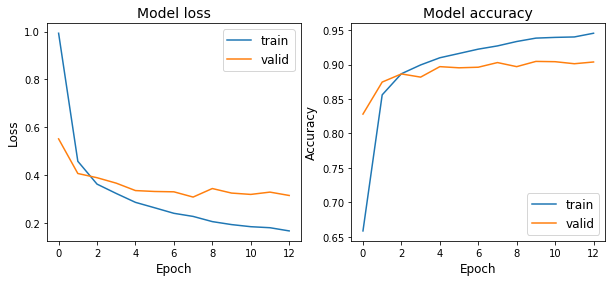

In [6]:
fig, ax = plot_training(log)

### Evaluating the trained model

Next, we want to evaluate our trained model on the testing set which has never been 'seen' before by the model. We can print the classification report and plot the confusion matrix calculated between true label and predicted label. Our results show that the model performance (average F1 score) on the testing set is 0.91 (pretty good).

2368/2368 [==============================] - 1s 250us/sample - loss: 0.3139 - accuracy: 0.9037
              precision    recall  f1-score      support
0              0.887967  0.906780  0.897275   236.000000
1              0.920561  0.827731  0.871681   238.000000
2              0.891129  0.936441  0.913223   236.000000
3              0.869919  0.899160  0.884298   238.000000
4              0.841897  0.902542  0.871166   236.000000
5              0.934498  0.902954  0.918455   237.000000
6              0.942731  0.902954  0.922414   237.000000
7              0.952991  0.936975  0.944915   238.000000
8              0.897541  0.920168  0.908714   238.000000
9              0.957627  0.949580  0.953586   238.000000
accuracy       0.908516  0.908516  0.908516     0.908516
macro avg      0.909686  0.908528  0.908573  2372.000000
weighted avg   0.909753  0.908516  0.908600  2372.000000


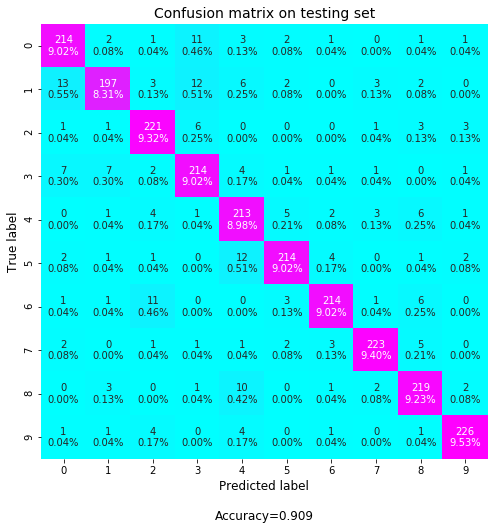

In [8]:
eval_score = model_tf.evaluate(x_valid,y_valid,batch_size=64)
y_pred_prob = model_tf.predict(x_test,batch_size=64)
y_pred_int = change.bin2int(y_pred_prob)
y_pred_str = change.bin2str(y_pred_prob)

test_report = classification_report(y_test_int, y_pred_int, output_dict=True)
df_test_report = pd.DataFrame(test_report).transpose()
print(df_test_report)

conf_mat = confusion_matrix(y_test_int,y_pred_int)
make_confusion_matrix(conf_mat, figsize=(8,8),cbar=False,title="Confusion matrix on testing set")

### Testing Model From Audio FIlename
In above evaluation, the input to the trained model is from the extracted features. Now, we want to test the trained model directly from the raw audio clip (indicated by its filename). Let's create a function named predict_audio that takes filename input and returns the predicted class (along with its probability). We can pick any filename by changing the file index (`idx`) value. An example result from first file is shown below.

In [9]:
# Select file index for prediction
idx = 0 # change for other file
filename = test_csv.iloc[idx,0]
def predict_audio(filename,feature='mfcc',model_type='lstm'):
    sr, audio = wavfile.read(filename)
    audio = pad_input(audio)
    if feature=='mfcc':
        x_feature = normalise_feature(extract_mfcc(audio))
    elif feature=='mel':
        x_feature = normalise_feature(extract_mel(audio))
    if model_type=='lstm':
        x_feature = np.array(x_feature.T)[np.newaxis,:,:]
    elif model_type=='cnn':
        x_feature = np.array(x_feature.T)[np.newaxis,:,:,np.newaxis]
    y_prob = model_tf.predict(x_feature,batch_size=1)
    y_str = change.bin2str(y_prob)
    
    print("Predicted label: {}".format(y_str[0])) 
    for i in range(y_prob.shape[1]): 
        print("Probability of {} \t: {:.6f}".format(labels[i],y_prob[0,i]))
        
predict_audio(test_csv.iloc[2,0],feature=feature,model_type=model_type)

Predicted label: down
Probability of down 	: 0.999054
Probability of go 	: 0.000748
Probability of left 	: 0.000003
Probability of no 	: 0.000071
Probability of off 	: 0.000006
Probability of on 	: 0.000014
Probability of right 	: 0.000022
Probability of stop 	: 0.000043
Probability of up 	: 0.000001
Probability of yes 	: 0.000039
